<h1>InstaCart EDA<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Prior-work/-previous-next-steps" data-toc-modified-id="Prior-work/-previous-next-steps-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Prior work/ previous next steps</a></span></li><li><span><a href="#Guiding-questions" data-toc-modified-id="Guiding-questions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Guiding questions</a></span></li><li><span><a href="#Key-findings" data-toc-modified-id="Key-findings-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Key findings</a></span></li><li><span><a href="#Related-notebooks" data-toc-modified-id="Related-notebooks-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Related notebooks</a></span></li><li><span><a href="#Imports-and-configurations" data-toc-modified-id="Imports-and-configurations-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Imports and configurations</a></span></li></ul></li><li><span><a href="#Ingest-data" data-toc-modified-id="Ingest-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Ingest data</a></span></li><li><span><a href="#Clean-and-process-data" data-toc-modified-id="Clean-and-process-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Clean and process data</a></span></li><li><span><a href="#Exploratory-data-analysis" data-toc-modified-id="Exploratory-data-analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Exploratory data analysis</a></span></li><li><span><a href="#Model-development" data-toc-modified-id="Model-development-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model development</a></span><ul class="toc-item"><li><span><a href="#Generate-features" data-toc-modified-id="Generate-features-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Generate features</a></span></li><li><span><a href="#Train-model" data-toc-modified-id="Train-model-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Train model</a></span></li><li><span><a href="#Score-model" data-toc-modified-id="Score-model-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Score model</a></span></li><li><span><a href="#Evaluate-model" data-toc-modified-id="Evaluate-model-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Evaluate model</a></span></li></ul></li><li><span><a href="#Post-process-and-analyze" data-toc-modified-id="Post-process-and-analyze-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Post-process and analyze</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Conclusions</a></span><ul class="toc-item"><li><span><a href="#Key-findings" data-toc-modified-id="Key-findings-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Key findings</a></span></li><li><span><a href="#Next-steps" data-toc-modified-id="Next-steps-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Next steps</a></span></li></ul></li></ul></div>

# Introduction

## Purpose
The purpose of this notebook is to explore the validity of using previous Instacart orders and the order in which items were added to a customer's shopping cart as a means for generating recommendations.

## Purior work/ previous next steps
NA

## Guiding questions
* Is there a subset of the data that will work for POC? Also this would help with the sparcity of the matrix.
* Is item based collaborative filtering a good method of clustering? 
* If so, how flexible (many neighbors) does the model need to be to return valid recommendations? 

## Key findings

## Related notebooks

* **Copied from:** N/A
* **Purpose of copy:** N/A 
* **Copied to:** N/A
* **Purpose of copy:** N/A
* **Related notebooks:** N/A

## Imports and configurations


In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import KNNBaseline, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from collections import defaultdict
color = sns.color_palette()

# Ingest data

In [2]:
orders = pd.read_csv("../data/order_products__train.csv")
products = pd.read_csv("../data/products.csv")

## Clean and process data

# Exploratory data analysis
* We are going to be focusing on: orders, the products included in orders, and the order by which products were added to an order

In [3]:
orders.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [4]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


#### Add to cart order exploration

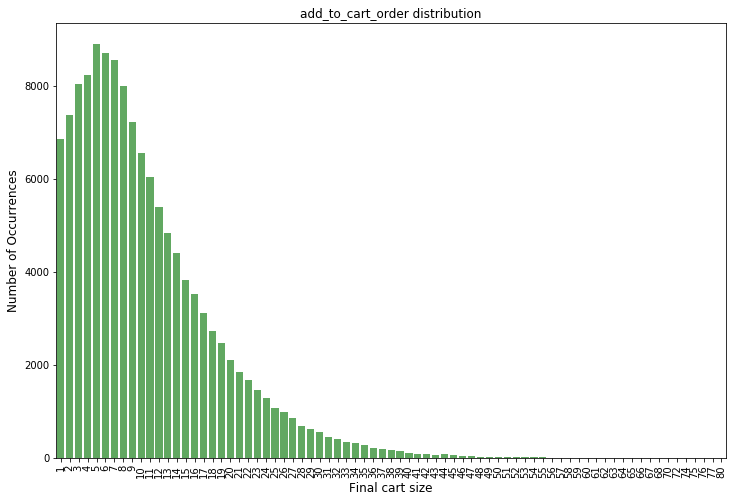

In [5]:
cnt_srs = orders.groupby("order_id")["add_to_cart_order"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Final cart size', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("add_to_cart_order distribution")
plt.show()

Here we can see that most order sizes are relatively small and that this distribution has a large right skew. Using this as a rating proxy would likely cause issues because the scale would have ot be from 1 to nearly 80-- perhaps putting these ratings on a log scale would help keep them in a reasonable/comprable range. 

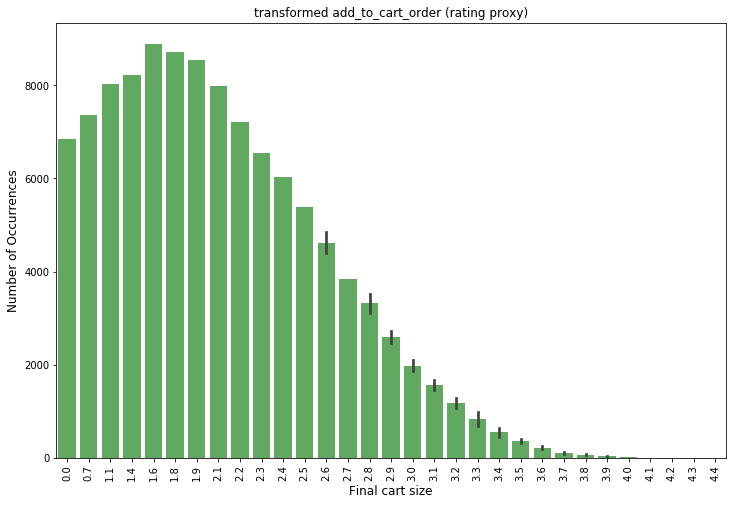

In [6]:
plt.figure(figsize=(12,8))
sns.barplot(np.round(np.log(cnt_srs.index),1), cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Final cart size', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("transformed add_to_cart_order (rating proxy)")
plt.show()

With the log scale we can see that the rating scale would be between 0 and 4.5, which is more reasonable. 

#### Items in orders exploration

In [7]:
# join the dataframes to see names or products rather than IDs
df = pd.merge(orders, products, on = 'product_id')[['order_id', 'product_name', 'product_id']]
df.head()

,order_id,product_name,product_id
0,1,Bulgarian Yogurt,49302
1,816049,Bulgarian Yogurt,49302
2,1242203,Bulgarian Yogurt,49302
3,1383349,Bulgarian Yogurt,49302
4,1787378,Bulgarian Yogurt,49302


In [8]:
# what are the 20 most popular items? 
pop_items = df['product_name'].value_counts().reset_index()
pop_items.columns = ['product_name', 'frequencey_count']
pop_items.head(20)

,product_name,frequencey_count
0,Banana,18726
1,Bag of Organic Bananas,15480
2,Organic Strawberries,10894
3,Organic Baby Spinach,9784
4,Large Lemon,8135
5,Organic Avocado,7409
6,Organic Hass Avocado,7293
7,Strawberries,6494
8,Limes,6033
9,Organic Raspberries,5546


In [9]:
# can we capure a large proportion of the 
# orders with significantly fewer products? 
pop_items['cum_sum'] = pop_items.frequencey_count.cumsum()
pop_items['cum_perc'] = 100*pop_items.cum_sum/pop_items.frequencey_count.sum()
pop_items.head()

,product_name,frequencey_count,cum_sum,cum_perc
0,Banana,18726,18726,1.352432
1,Bag of Organic Bananas,15480,34206,2.470430
2,Organic Strawberries,10894,45100,3.257218
3,Organic Baby Spinach,9784,54884,3.963840
4,Large Lemon,8135,63019,4.551367


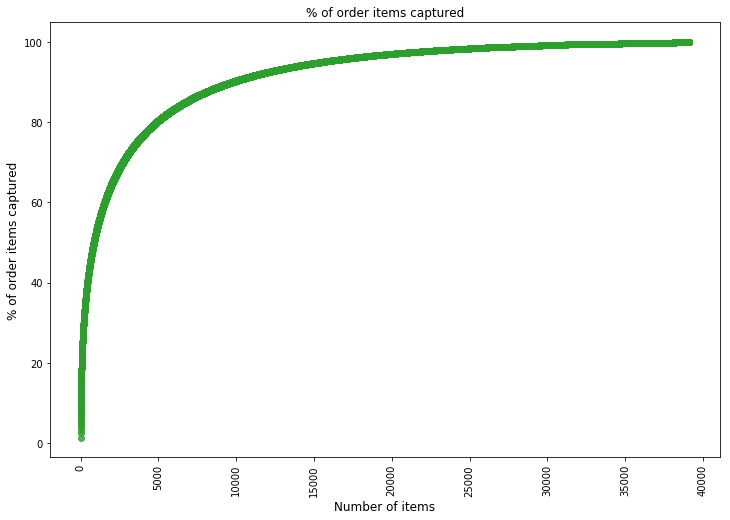

In [10]:
plt.figure(figsize=(12,8))
sns.regplot(pop_items.index, pop_items.cum_perc, color=color[2], fit_reg=False)
plt.ylabel('% of order items captured', fontsize=12)
plt.xlabel('Number of items', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("% of order items captured")
plt.show()

We can capture 50% of all items included in orders with only 852 items! This only represents 1.7% of the items Instacart has to offer! This seems like a decent amount of items to include on the website without having to suffer through UI/UX (out of the scope of this project).

In [11]:
pop_items.loc[(pop_items.cum_perc < 50.2) & (pop_items.cum_perc > 50)]

,product_name,frequencey_count,cum_sum,cum_perc
852,Strawberry Rhubarb Yogurt,262,692409,50.007258
853,Mache Rosettes French Salad Mix,262,692671,50.026181
854,Organic Large Grade AA Omega-3 Eggs,262,692933,50.045103
855,Mozzarella Cheese,262,693195,50.064025
856,Classic Hummus Family Size,261,693456,50.082875
857,Peanut Butter Ice Cream Cup,261,693717,50.101725
858,Grape Tomatoes,261,693978,50.120575
859,Classic Soda,261,694239,50.139425
860,Organic Whole Milk,260,694499,50.158203
861,Organic Genoa Salami,260,694759,50.176980


In [12]:
852/products.shape[0]

0.017146997262920623

# Model development

Retrieve the 852 `product_ids` to include in our recommendation engine and subset `orders` dataframe to only include the rows with these items. 

In [13]:
pop_items_id = df['product_id'].value_counts().reset_index()
pop_items_id.columns = ['product_id', 'frequencey_count']
id_subset = pop_items_id.head(853)
id_subset = id_subset.product_id

sub_orders = orders[orders.product_id.isin(id_subset)]
sub_orders.shape[0]/orders.shape[0] # confirmed, 50% of rows are captured

0.5000725832486529

## Generate features

Set up dataset for `Surprise` library. This dataframe needs the columns `order_id`, `product`, and `rating`. Because of the assumption that people add similar items to their shopping cart in sequential order, we will use add_to_cart_order as a proxy for a rating. As discussed in the EDA section, we will take the log of this to generate a reasonable rating scale. 

In [14]:
sub_orders['rating'] = np.log(sub_orders.add_to_cart_order)
sub_orders = sub_orders[['order_id', 'product_id', 'rating']]
sub_orders.head()

/Users/sarahgreenwood/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,order_id,product_id,rating
2,1,10246,1.098612
3,1,49683,1.386294
5,1,13176,1.791759
6,1,47209,1.945910
7,1,22035,2.079442


## Train model

In [15]:
my_seed = 42
random.seed(my_seed)
np.random.seed(my_seed)

In [187]:
# format subset of data for Surprise package
reader = Reader(rating_scale=(max(sub_orders.rating), min(sub_orders.rating)))
dat = Dataset.load_from_df(sub_orders, reader)
dat

In [34]:
# split into train and test splits
trainset, testset = train_test_split(dat, test_size=.25)

In [92]:
# build model
sim_options = {
    'name': 'pearson_baseline', 
    'user_based': False}
algo = KNNBaseline(k=10, sim_options = sim_options)
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


## Score model

In [93]:
# evaluate model
predictions = algo.test(testset)

In [107]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each order.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort order ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [110]:
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=2)

## Evaluate model

* Precision = proportion of predicted to-be purchased items that actually were purchased
* Recall = proportion of purchased items that were identified (closest neighbor)

In [111]:
# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

0.33257704435655094
0.9904966957777002


# Post-process and analyze

While these precision/recall metrics are helpful mathematically, they do not help us do a qualitative evaluation of the recommender. Let's see some products that are recommended! 

As a reminder, valid items are in the `sub_orders` dataframe.

In [188]:
# build model
# format subset of data for Surprise package
dat = dat.build_full_trainset()
sim_options = {
    'name': 'pearson_baseline', 
    'user_based': False}
algo = KNNBaseline(k=10, sim_options = sim_options)
algo.fit(dat)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [189]:
def read_item_names(products,fit):
    rid_to_name = {}
    for i in range(0,len(products)):
        try:
            if fit.trainset.knows_item(fit.trainset.to_inner_iid(products.product_id[i])):
                rid_to_name[str(products.product_id[i])] = products.product_name[i]
        except:
            pass
    return(rid_to_name)

In [215]:
def give_recommendation(model, raw_id, key):
    print("  YOU ORDERED: \n" + key[raw_id])
    try:
        inner_id = model.trainset.to_inner_iid(int(raw_id))
        inner_rec = model.get_neighbors(inner_id, 5)
        raw_recs = [model.trainset.to_raw_iid(inner_id) for inner_id in inner_rec]
        neighbors = [key[str(rid)] for rid in raw_recs]
        print("  YOU MAY ALSO LIKE: ")
        print(*neighbors, sep='\n')
    except: 
        return("RECOMMEND POPULAR ITEMS")

In [219]:
for item in sub_orders.product_id.sample(3):
    give_recommendation(algo, str(item), key)
    print("\n")

  YOU ORDERED: 
Purity Farms Ghee Clarified Butter
  YOU MAY ALSO LIKE: 
Asparagus
Organic Raspberries
Limes
Organic Baby Spinach
Organic Cilantro


  YOU ORDERED: 
Honeydew Melon
  YOU MAY ALSO LIKE: 
Cantaloupe
Blackberries
Seedless Red Grapes
Raspberries
Broccoli Crown


  YOU ORDERED: 
Asparagus
  YOU MAY ALSO LIKE: 
Brussels Sprouts
Organic Russet Potato
Organic Lemon
Organic Red Radish, Bunch
Organic Green Cabbage




# Conclusions

## Key findings

* We can capture a ~50% of order items with 1.7% of the items offered by InstaCart
* Subsetting data is important for reducing sparsity of data
* We were able to make an item-based collaborative filtering method
* The best item recommendations appear to be in the same aisle 
* Centering "ratings" and reducing the number of neighbors generates flexibility required for unique yet applicable recommendations

## Next steps

* Move current notebook functionality to scripts
* Reassess data in ratings database table
* If further model development/improvements are required-- investigate various skus of products